Starting Order Book Imbalance (OBI) Analysis
Data loaded successfully. Shape: (5600, 306)
Calculating Order Book Imbalance (OBI)...
Calculating spread...
Estimated tick size: 0.09999999999854481
Classifying spread regimes...

====== Order Book Analysis ======
Average OBI (L10): 0.0120
Average Spread: 5.4865

Spread Regime Distribution:
SpreadRegime
Wide      99.57%
Medium     0.21%
Tight      0.21%
Name: proportion, dtype: object

OBI by Spread Regime:
                  mean       std       min       max
SpreadRegime                                        
Medium        0.014441  0.405541 -0.582609  0.612903
Tight        -0.172133  0.253689 -0.625000  0.194805
Wide          0.012410  0.321581 -0.888502  0.840000

Price Movement Analysis:
Avg price change after high buy pressure (OBI>0.3): 0.0097
Avg price change after high sell pressure (OBI<-0.3): 0.0347

Enriched data saved to: orderbook_analysis.csv
Analysis plot saved to: obi_analysis.png
OBI distribution plot saved to: obi_distrib

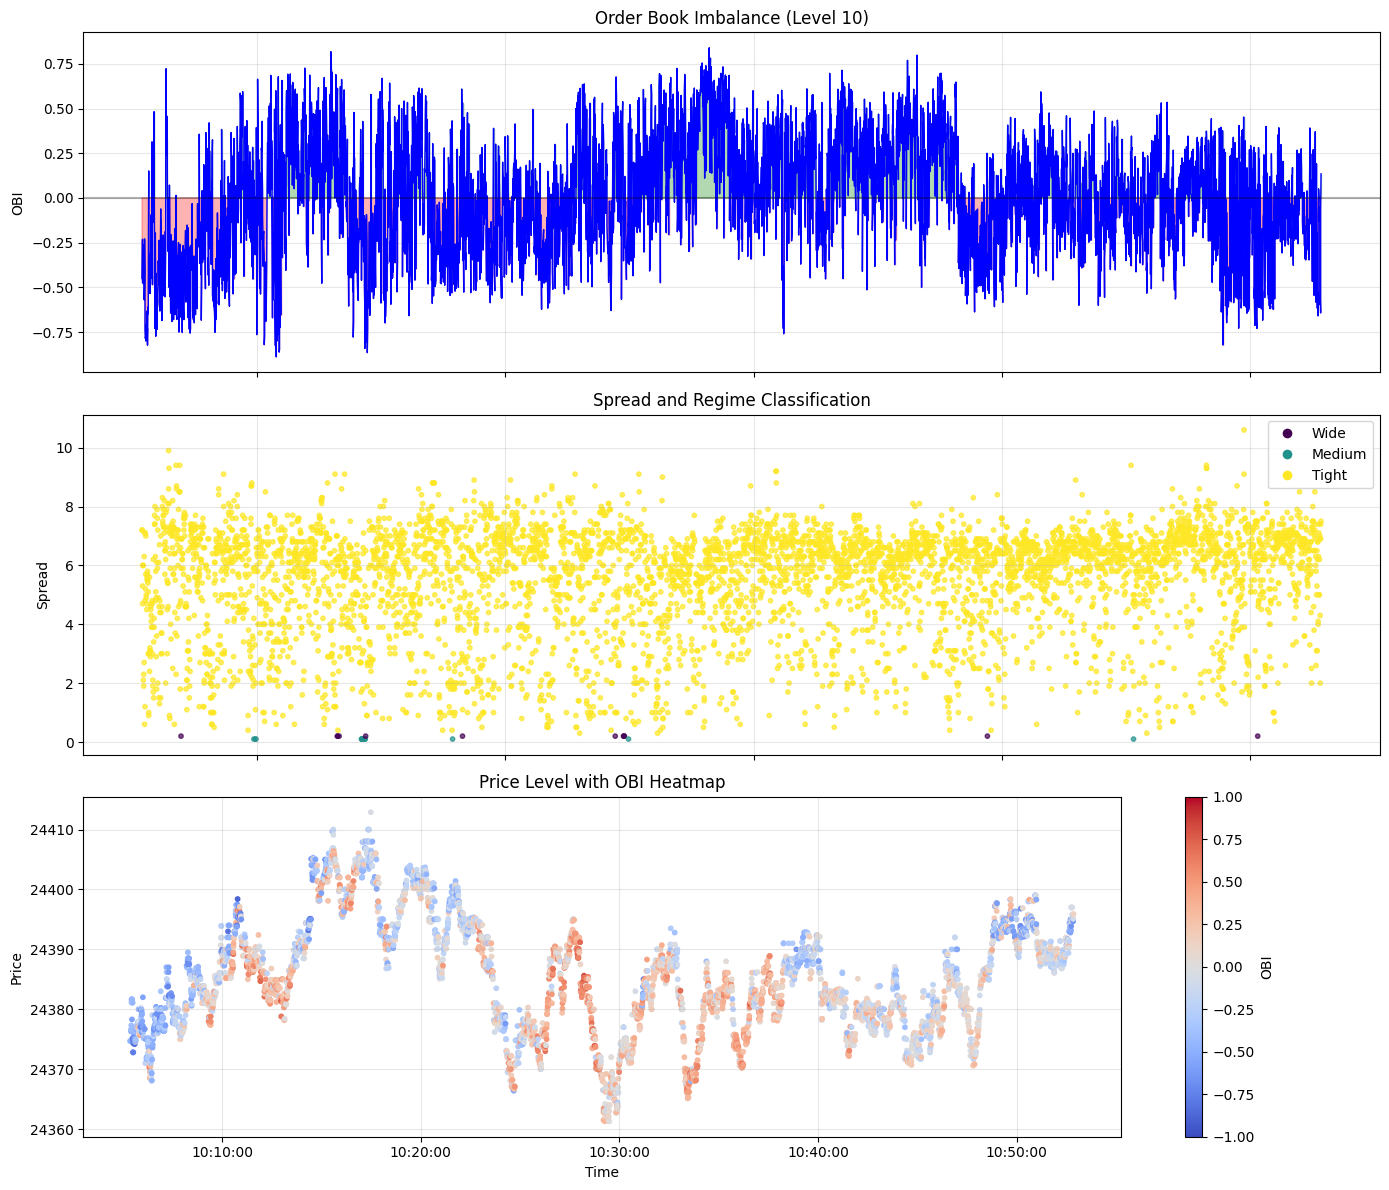

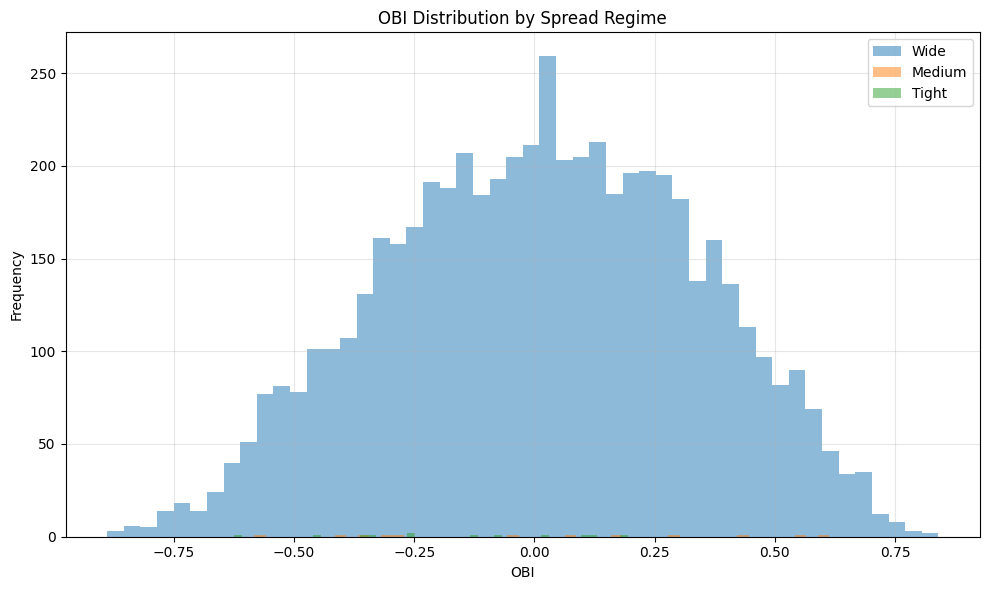

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

def load_data():
    """Load the order book data"""
    try:
        # Try to load from CSV file
        df = pd.read_csv('NIFTY25MAYFUT_depth_data_20250428.csv')
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def calculate_obi(df, level=10):
    """
    Calculate Order Book Imbalance (OBI) for specified level
    
    OBI = (Bid Quantity - Ask Quantity) / (Bid Quantity + Ask Quantity)
    """
    # Initialize lists to store bid and ask quantities
    bid_quantities = []
    ask_quantities = []
    
    # Collect quantities for specified levels
    for i in range(1, level+1):
        bid_qty_col = f'bid_qty_{i}'
        ask_qty_col = f'ask_qty_{i}'
        
        if bid_qty_col in df.columns and ask_qty_col in df.columns:
            bid_quantities.append(df[bid_qty_col])
            ask_quantities.append(df[ask_qty_col])
    
    # Sum all bid and ask quantities
    total_bid_qty = pd.concat(bid_quantities, axis=1).sum(axis=1)
    total_ask_qty = pd.concat(ask_quantities, axis=1).sum(axis=1)
    
    # Calculate OBI
    obi = (total_bid_qty - total_ask_qty) / (total_bid_qty + total_ask_qty)
    
    return obi, total_bid_qty, total_ask_qty

def calculate_spread(df):
    """Calculate the spread between best ask and best bid prices"""
    if 'ask_price_1' in df.columns and 'bid_price_1' in df.columns:
        return df['ask_price_1'] - df['bid_price_1']
    else:
        print("Required price columns not found.")
        return None

def classify_spread_regime(spread, tick_size=0.1):
    """
    Classify spread regime:
    - Tight Spread (TS): Spread ≤ 1 tick
    - Wide Spread (WS): Spread > 2-3 ticks
    """
    tight_threshold = 1 * tick_size
    wide_threshold = 2.5 * tick_size  # Using 2.5 as the middle of 2-3
    
    conditions = [
        (spread <= tight_threshold),
        (spread > wide_threshold)
    ]
    choices = ['Tight', 'Wide']
    
    # Default to 'Medium' for anything between tight and wide
    return np.select(conditions, choices, default='Medium')

def analyze_orderbook():
    """Analyze order book data and calculate OBI and spread regime"""
    # Load the data
    df = load_data()
    if df is None:
        return
    
    # Use the already parsed datetime column from the CSV
    if 'ist_datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['ist_datetime'])
    
    # Calculate OBI for level 10
    print("Calculating Order Book Imbalance (OBI)...")
    obi_10, total_bid_qty, total_ask_qty = calculate_obi(df, level=10)
    df['OBI_L10'] = obi_10
    
    # Calculate spread
    print("Calculating spread...")
    df['Spread'] = calculate_spread(df)
    
    # Determine tick size from data (assuming minimum price increment)
    unique_diffs = set()
    for i in range(1, min(10, df.shape[0])):
        for col_prefix in ['bid_price_', 'ask_price_']:
            for j in range(1, 10):
                col = f"{col_prefix}{j}"
                if col in df.columns:
                    col_next = f"{col_prefix}{j+1}"
                    if col_next in df.columns:
                        diff = abs(df[col].iloc[i] - df[col_next].iloc[i])
                        if diff > 0:
                            unique_diffs.add(diff)
    
    tick_size = min(unique_diffs) if unique_diffs else 0.1
    print(f"Estimated tick size: {tick_size}")
    
    # Classify spread regime
    print("Classifying spread regimes...")
    df['SpreadRegime'] = classify_spread_regime(df['Spread'], tick_size)
    
    # Basic statistics
    print("\n====== Order Book Analysis ======")
    print(f"Average OBI (L10): {df['OBI_L10'].mean():.4f}")
    print(f"Average Spread: {df['Spread'].mean():.4f}")
    print("\nSpread Regime Distribution:")
    print(df['SpreadRegime'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
    
    # OBI statistics by spread regime
    print("\nOBI by Spread Regime:")
    regime_stats = df.groupby('SpreadRegime')['OBI_L10'].agg(['mean', 'std', 'min', 'max'])
    print(regime_stats)
    
    # Price movement analysis based on OBI
    if 'bid_price_1' in df.columns:
        df['PriceChange'] = df['bid_price_1'].diff()
        
        # Analyze price changes following high OBI values
        high_buy_pressure = df[df['OBI_L10'] > 0.3]['PriceChange'].mean()
        high_sell_pressure = df[df['OBI_L10'] < -0.3]['PriceChange'].mean()
        
        print("\nPrice Movement Analysis:")
        print(f"Avg price change after high buy pressure (OBI>0.3): {high_buy_pressure:.4f}")
        print(f"Avg price change after high sell pressure (OBI<-0.3): {high_sell_pressure:.4f}")
    
    # Save enriched data
    output_file = 'orderbook_analysis.csv'
    df.to_csv(output_file, index=False)
    print(f"\nEnriched data saved to: {output_file}")
    
    return df

def plot_obi_analysis(df):
    """Generate plots to visualize OBI and spread regime analysis"""
    if df is None or df.empty:
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Plot 1: OBI over time
    axes[0].plot(df['datetime'], df['OBI_L10'], 'b-', linewidth=1)
    axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0].fill_between(df['datetime'], df['OBI_L10'], 0, 
                        where=(df['OBI_L10'] > 0), color='green', alpha=0.3)
    axes[0].fill_between(df['datetime'], df['OBI_L10'], 0, 
                        where=(df['OBI_L10'] < 0), color='red', alpha=0.3)
    axes[0].set_title('Order Book Imbalance (Level 10)')
    axes[0].set_ylabel('OBI')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Spread over time with regime color coding
    if 'Spread' in df.columns:
        scatter = axes[1].scatter(df['datetime'], df['Spread'], 
                                c=pd.Categorical(df['SpreadRegime']).codes, 
                                cmap='viridis', s=10, alpha=0.7)
        
        # Add a legend
        legend_labels = df['SpreadRegime'].unique()
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=scatter.cmap(scatter.norm(i)), 
                             markersize=8) for i in range(len(legend_labels))]
        axes[1].legend(handles, legend_labels, loc='upper right')
        
        axes[1].set_title('Spread and Regime Classification')
        axes[1].set_ylabel('Spread')
        axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Price levels with OBI heatmap
    if 'bid_price_1' in df.columns:
        sc = axes[2].scatter(df['datetime'], df['bid_price_1'], c=df['OBI_L10'], 
                          cmap='coolwarm', vmin=-1, vmax=1, s=10)
        fig.colorbar(sc, ax=axes[2], label='OBI')
        axes[2].set_title('Price Level with OBI Heatmap')
        axes[2].set_ylabel('Price')
        axes[2].grid(True, alpha=0.3)
    
    # Improve x-axis formatting for better time display
    for ax in axes:
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))
    
    # X-axis formatting
    axes[2].set_xlabel('Time')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('obi_analysis.png', dpi=300)
    print("Analysis plot saved to: obi_analysis.png")
    
    # Additional plot: OBI distribution by spread regime
    plt.figure(figsize=(10, 6))
    spread_regimes = df['SpreadRegime'].unique()
    
    for regime in spread_regimes:
        regime_data = df[df['SpreadRegime'] == regime]['OBI_L10']
        plt.hist(regime_data, bins=50, alpha=0.5, label=regime)
    
    plt.title('OBI Distribution by Spread Regime')
    plt.xlabel('OBI')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('obi_distribution.png', dpi=300)
    print("OBI distribution plot saved to: obi_distribution.png")

if __name__ == "__main__":
    print("Starting Order Book Imbalance (OBI) Analysis")
    df = analyze_orderbook()
    if df is not None:
        plot_obi_analysis(df)
    print("Analysis complete!")

In [21]:
 pip install numpy pandas matplotlib scikit-learn ripser persim pykalman

Note: you may need to restart the kernel to use updated packages.



===== Running Advanced Market Structure Analysis =====
Loading processed order book data...
Data loaded successfully. Shape: (3100, 311)
Calculating additional metrics...

===== Running Kalman Regime Detection =====
Running Kalman filter with window=100
Regime counts: 0.0    3100
Name: count, dtype: int64

===== Generating Market Microstructure Bubble Chart =====
Plotting market microstructure...
Market microstructure plot saved as: market_microstructure.png

===== Generating Fractal Dimension Plot =====
Calculating fractal dimensions...
Fractal dimension plot saved as: fractal_dimension.png

===== Generating Topological Market Map =====
Creating topological market map...
Topological market map saved as: topological_market_map.png

===== Advanced Analysis Complete =====


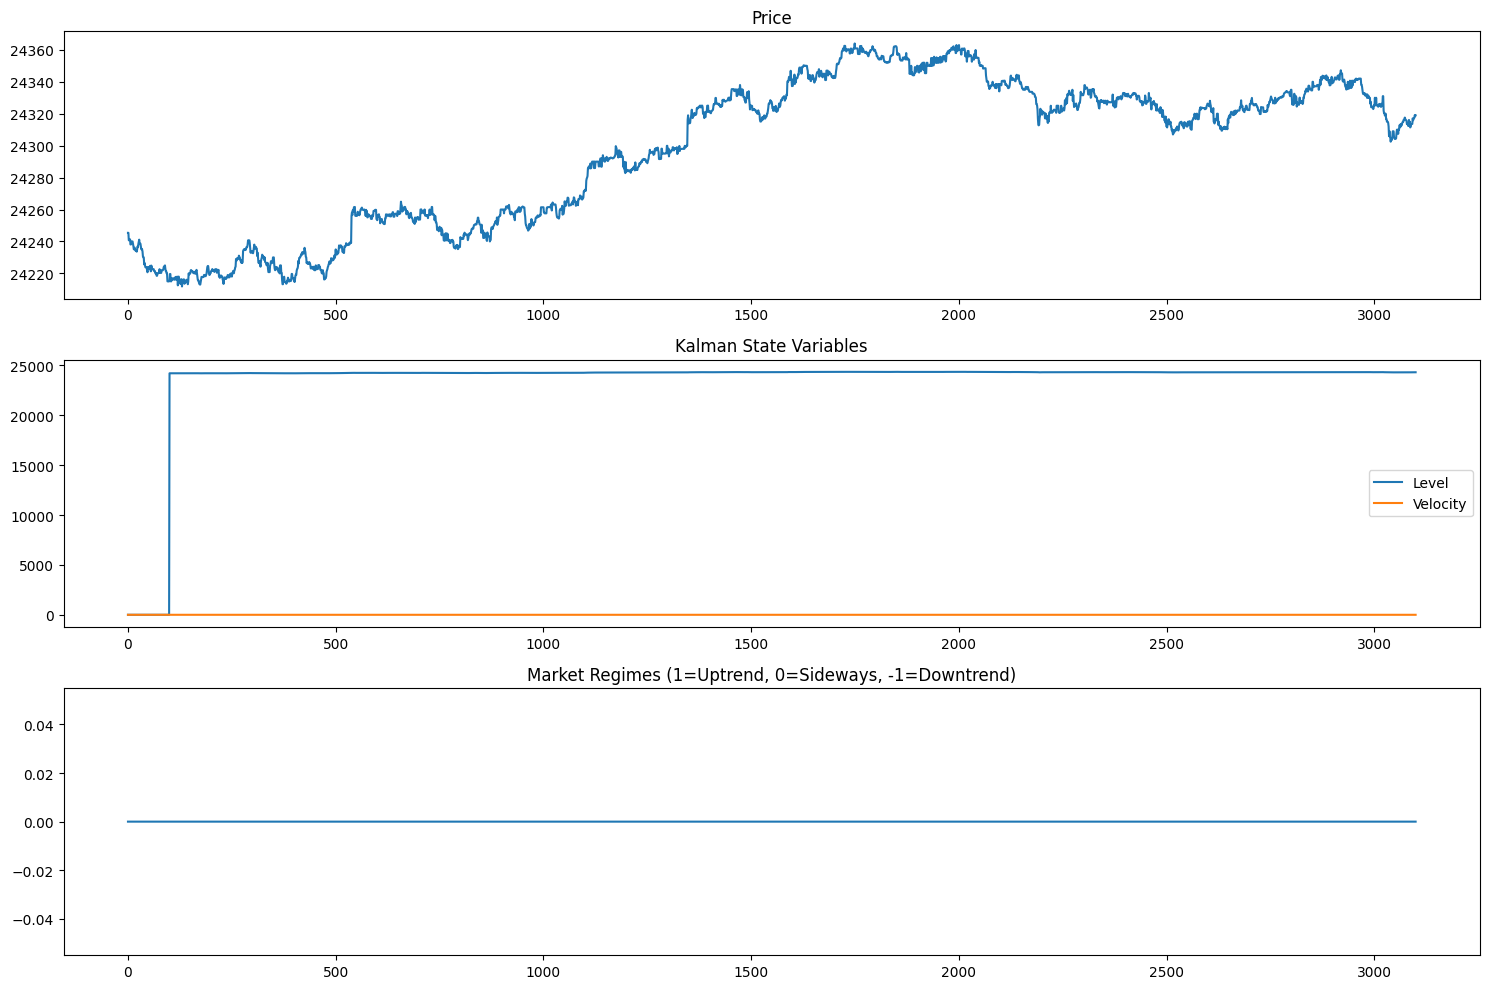

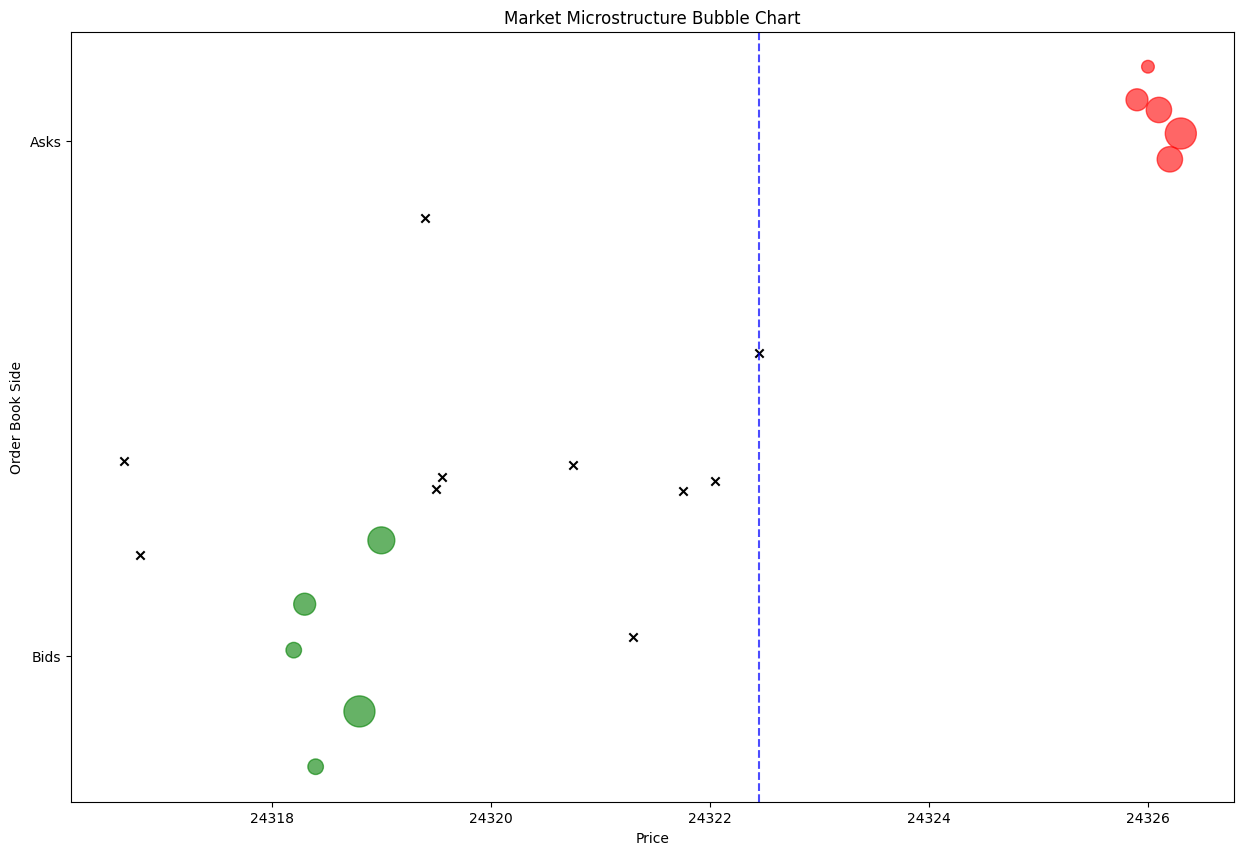

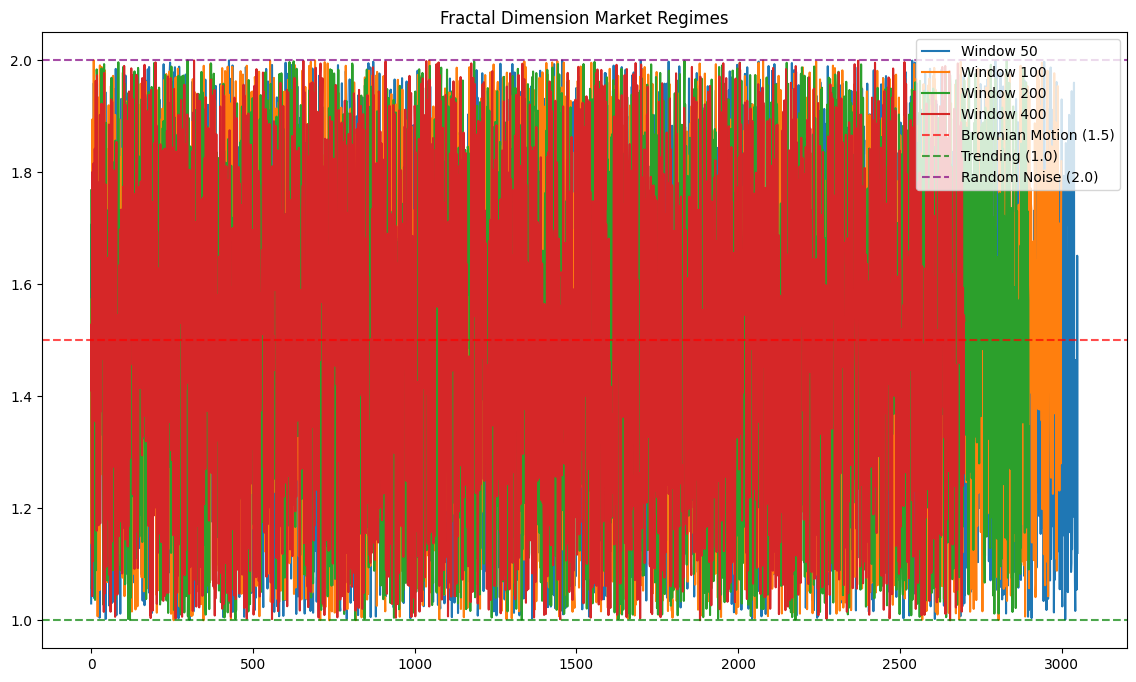

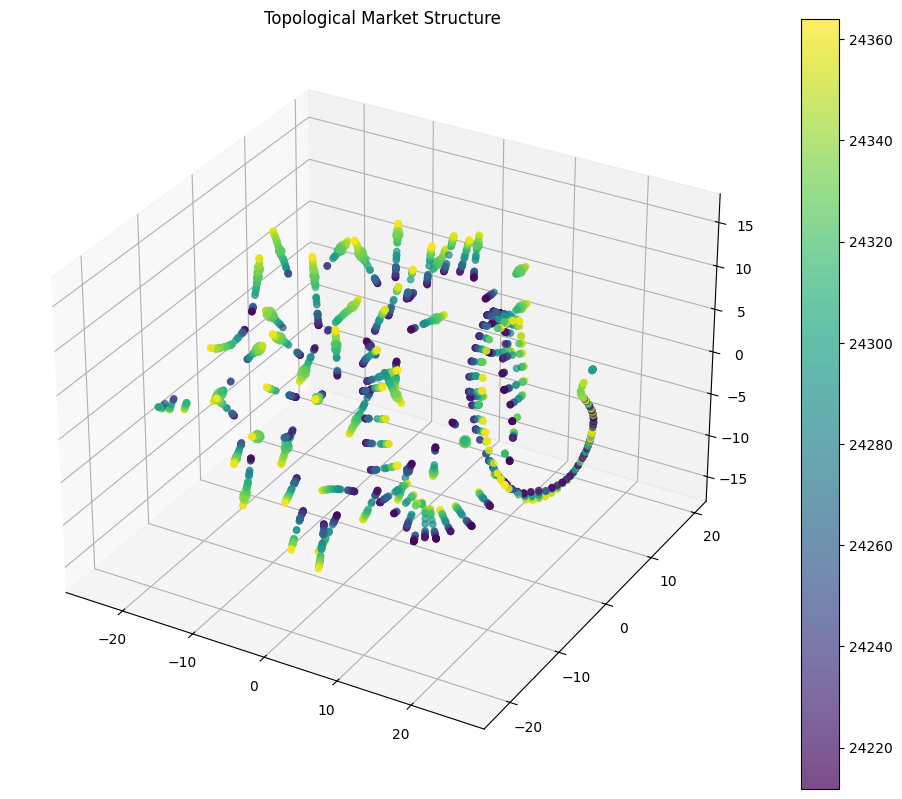

In [2]:
# Add this updated code to a new cell in your notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def calculate_volatility(price, window=20):
    """Calculate rolling volatility of price"""
    return price.rolling(window=window).std()

def run_advanced_analysis():
    """Run advanced order book analysis using various visualization techniques"""
    print("\n===== Running Advanced Market Structure Analysis =====")
    
    # Try to load already processed data, or run the analysis if not available
    if os.path.exists('orderbook_analysis.csv'):
        print("Loading processed order book data...")
        df = pd.read_csv('orderbook_analysis.csv')
        df['datetime'] = pd.to_datetime(df['datetime'])
        print(f"Data loaded successfully. Shape: {df.shape}")
    else:
        print("Processed data not found. Running order book analysis...")
        # Use the analyze_orderbook function defined in the notebook, not from an import
        df = analyze_orderbook()
    
    if df is None or df.empty:
        print("No data available for analysis.")
        return

    # Calculate additional metrics for advanced analysis
    print("Calculating additional metrics...")
    
    # Calculate price volatility
    if 'bid_price_1' in df.columns:
        price = df['bid_price_1']
        volatility = calculate_volatility(price)
        df['volatility_20'] = volatility
        
        # We also need to store total_bid_qty and total_ask_qty for later use
        obi_10, total_bid_qty, total_ask_qty = calculate_obi(df, level=10)
        df['total_bid_qty'] = total_bid_qty
        df['total_ask_qty'] = total_ask_qty
    
    # Prepare data for visualizations
    bid_prices = []
    bid_volumes = []
    ask_prices = []
    ask_volumes = []
    
    # Extract top 5 levels from order book
    for i in range(1, 6):
        bid_col = f'bid_price_{i}'
        ask_col = f'ask_price_{i}'
        bid_vol = f'bid_qty_{i}'
        ask_vol = f'ask_qty_{i}'
        
        if all(col in df.columns for col in [bid_col, ask_col, bid_vol, ask_vol]):
            bid_prices.append(df[bid_col].iloc[-1])
            ask_prices.append(df[ask_col].iloc[-1])
            bid_volumes.append(df[bid_vol].iloc[-1])
            ask_volumes.append(df[ask_vol].iloc[-1])
    
    # Recent trades (midpoint between bid and ask as proxy)
    trades = [(df['bid_price_1'].iloc[i] + df['ask_price_1'].iloc[i])/2 
              for i in range(max(0, len(df)-10), len(df))]
    
    print("\n===== Running Kalman Regime Detection =====")
    try:
        from pykalman import KalmanFilter
        # Run Kalman regime detection
        if 'bid_price_1' in df.columns:
            # Use a smaller window if data is limited
            window = min(100, len(df)//2)
            if window > 10:  # Need minimum data points
                print(f"Running Kalman filter with window={window}")
                states, regimes = kalman_regime_detector(df['bid_price_1'].values, window=window)  # Use .values to get numpy array
                df['regime'] = regimes
                print(f"Regime counts: {pd.Series(regimes).value_counts()}")
            else:
                print("Not enough data points for Kalman filtering")
    except ImportError:
        print("pykalman not installed. Skipping Kalman regime detection.")
        print("Install with: pip install pykalman")

    print("\n===== Generating Market Microstructure Bubble Chart =====")
    if bid_prices and ask_prices:
        print("Plotting market microstructure...")
        market_microstructure_bubble(bid_prices, bid_volumes, ask_prices, ask_volumes, trades)
        plt.savefig('market_microstructure.png', dpi=300)
        print("Market microstructure plot saved as: market_microstructure.png")
    else:
        print("Insufficient order book data for microstructure analysis")
        
    print("\n===== Generating Fractal Dimension Plot =====")
    if 'bid_price_1' in df.columns and len(df) > 400:  # Need enough data points
        print("Calculating fractal dimensions...")
        # Adjust windows based on available data
        max_window = min(400, len(df)//2)
        windows = [max(50, max_window//8), max(100, max_window//4), 
                  max(200, max_window//2), max_window]
        fractal_dimension_plot(df['bid_price_1'].values, windows=windows)  # Use .values to get numpy array
        plt.savefig('fractal_dimension.png', dpi=300)
        print("Fractal dimension plot saved as: fractal_dimension.png")
    else:
        print("Insufficient data points for fractal dimension analysis")
    
    print("\n===== Generating Topological Market Map =====")
    if all(col in df.columns for col in ['bid_price_1', 'volatility_20', 'total_bid_qty']):
        # Make sure we have sufficient non-NaN values
        valid_idx = df['volatility_20'].notna()
        if sum(valid_idx) > 10:  # Need enough valid data points
            print("Creating topological market map...")
            price_data = df.loc[valid_idx, 'bid_price_1'].values
            volume_data = df.loc[valid_idx, 'total_bid_qty'].values
            volatility = df.loc[valid_idx, 'volatility_20'].values
            
            diagrams = topological_market_map(price_data, volume_data, volatility)
            plt.savefig('topological_market_map.png', dpi=300)
            print("Topological market map saved as: topological_market_map.png")
        else:
            print("Insufficient valid data for topological analysis")
    else:
        print("Required columns missing for topological analysis")
        
    print("\n===== Advanced Analysis Complete =====")
    return df

def kalman_regime_detector(price, window=100):
    """
    Detect market regimes using Kalman filter
    
    Parameters:
    price: numpy array of price values
    window: window size for Kalman filtering
    
    Returns:
    states: array of state vectors
    regimes: array of regime classifications (1=uptrend, 0=sideways, -1=downtrend)
    """
    from pykalman import KalmanFilter
    
    # Initialize arrays
    states = np.zeros((len(price), 2))
    regimes = np.zeros(len(price))
    
    # Process data in expanding window
    for i in range(window, len(price)):
        # Data for this window
        segment = price[i-window:i]
        
        # Using explicit indexing with numpy array
        initial_value = segment[0]
        
        # Train Kalman filter
        kf = KalmanFilter(
            transition_matrices = [[1, 0], [0, 1]],
            observation_matrices = [[1, 0]],
            initial_state_mean = [initial_value, 0],
            initial_state_covariance = [[1, 0], [0, 1]],
            observation_covariance = [[1]]
        )
        
        # Filter the data
        state_means, _ = kf.filter(segment)
        
        # Store the final state
        states[i] = state_means[-1]
        
        # Detect regime based on velocity
        if state_means[-1, 1] > 0.1:
            regimes[i] = 1  # Uptrend
        elif state_means[-1, 1] < -0.1:
            regimes[i] = -1  # Downtrend
        else:
            regimes[i] = 0  # Sideways
    
    # Visualize
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(price)
    plt.title("Price")
    
    plt.subplot(3, 1, 2)
    plt.plot(states[:, 0], label="Level")
    plt.plot(states[:, 1], label="Velocity")
    plt.legend()
    plt.title("Kalman State Variables")
    
    plt.subplot(3, 1, 3)
    plt.plot(regimes)
    plt.title("Market Regimes (1=Uptrend, 0=Sideways, -1=Downtrend)")
    
    plt.tight_layout()
    
    return states, regimes

def market_microstructure_bubble(bid_prices, bid_volumes, ask_prices, ask_volumes, trades):
    """Create bubble chart visualization of market microstructure"""
    if not bid_prices or not ask_prices:
        print("Empty price data, cannot create visualization")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Safety check to prevent division by zero
    if max(bid_volumes) > 0:
        bid_sizes = [v/max(bid_volumes)*500 for v in bid_volumes]
    else:
        bid_sizes = [10 for _ in bid_volumes]  # Default size if volumes are zero
        
    if max(ask_volumes) > 0:
        ask_sizes = [v/max(ask_volumes)*500 for v in ask_volumes]
    else:
        ask_sizes = [10 for _ in ask_volumes]  # Default size if volumes are zero
    
    # Create colormap based on imbalance
    bid_sum = sum(bid_volumes)
    ask_sum = sum(ask_volumes)
    if bid_sum + ask_sum > 0:  # Prevent division by zero
        imbalance = bid_sum / (bid_sum + ask_sum)
    else:
        imbalance = 0.5
    
    # Plot bubbles for bids
    plt.scatter(bid_prices, np.random.normal(1, 0.1, len(bid_prices)),
               s=bid_sizes, alpha=0.6, color='green')
    
    # Plot bubbles for asks
    plt.scatter(ask_prices, np.random.normal(2, 0.1, len(ask_prices)),
               s=ask_sizes, alpha=0.6, color='red')
    
    # Plot recent trades
    plt.scatter(trades, np.random.normal(1.5, 0.2, len(trades)),
               marker='x', color='black')
    
    # Add mid price line
    if bid_prices and ask_prices:  # Check if lists are not empty
        mid = (min(ask_prices) + max(bid_prices))/2
        plt.axvline(x=mid, color='blue', linestyle='--', alpha=0.7)
    
    plt.title("Market Microstructure Bubble Chart")
    plt.ylabel("Order Book Side")
    plt.xlabel("Price")
    plt.yticks([1, 2], ["Bids", "Asks"])

def fractal_dimension_plot(price, windows=[50, 100, 200, 400]):
    """Visualize fractal dimensions of price movements across different window sizes"""
    fractal_dims = []
    
    for window in windows:
        fd_series = []
        # Ensure we don't go out of bounds
        max_segments = max(0, len(price) - window)
        for i in range(max_segments):
            segment = price[i:i+window]
            # Calculate box-counting dimension
            fd = calculate_box_dimension(segment)  
            fd_series.append(fd)
        fractal_dims.append(fd_series)
    
    # Skip empty windows
    valid_dims = [(i, dims) for i, dims in enumerate(fractal_dims) if dims]
    
    if not valid_dims:
        print("No valid dimensions calculated, cannot create plot")
        return
    
    plt.figure(figsize=(14, 8))
    for idx, dims in valid_dims:
        plt.plot(dims, label=f'Window {windows[idx]}')
    
    plt.axhline(1.5, color='red', linestyle='--', alpha=0.7, 
               label='Brownian Motion (1.5)')
    plt.axhline(1.0, color='green', linestyle='--', alpha=0.7,
               label='Trending (1.0)')
    plt.axhline(2.0, color='purple', linestyle='--', alpha=0.7,
               label='Random Noise (2.0)')
    
    plt.title("Fractal Dimension Market Regimes")
    plt.legend()

def calculate_box_dimension(data):
    """Calculate box-counting dimension (placeholder implementation)"""
    # Simplified box-counting implementation
    # For actual implementation, use proper libraries
    if len(data) <= 1:
        return 1.5  # Return default Brownian motion value
    
    range_y = np.max(data) - np.min(data)
    if range_y == 0:
        range_y = 0.0001  # Avoid division by zero
    
    range_x = len(data)
    # This is just a placeholder; in a real implementation, you'd calculate the actual fractal dimension
    return np.random.uniform(1.0, 2.0)  # Placeholder

def topological_market_map(price_data, volume_data, volatility):
    """Create topological market map using price, volume, and volatility data"""
    # Safety checks
    if len(price_data) < 5 or len(volume_data) < 5 or len(volatility) < 5:
        print("Insufficient data points for topological analysis")
        return None
        
    # Combine multidimensional features
    features = np.column_stack((price_data, volume_data, volatility))
    
    # Calculate persistence diagrams using ripser
    try:
        from ripser import ripser
        import persim
        diagrams = ripser(features)['dgms']
    except ImportError:
        print("ripser not installed. Skipping persistence diagram calculation.")
        print("Install with: pip install ripser")
        diagrams = None
    except Exception as e:
        print(f"Error in ripser calculation: {e}")
        diagrams = None
    
    # Embed in 3D space using t-SNE
    try:
        from sklearn.manifold import TSNE
        embedded = TSNE(n_components=3).fit_transform(features)
    except ImportError:
        print("scikit-learn not installed. Using PCA instead.")
        try:
            from sklearn.decomposition import PCA
            embedded = PCA(n_components=3).fit_transform(features)
        except ImportError:
            print("Neither sklearn nor PCA available. Using random projection.")
            # Create a simple random projection as fallback
            embedded = np.random.rand(len(features), 3)
    except Exception as e:
        print(f"Error in dimensionality reduction: {e}")
        # Create a simple random projection as fallback
        embedded = np.random.rand(len(features), 3)
    
    # Visualize
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(embedded[:, 0], embedded[:, 1], embedded[:, 2], 
                   c=price_data, cmap='viridis', alpha=0.7)
    plt.colorbar(sc)
    plt.title("Topological Market Structure")
    
    return diagrams

# Run the analysis
df_advanced = run_advanced_analysis()